In [1]:

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import shutil
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
source_dir = '/kaggle/input/cell-images-for-detecting-malaria/cell_images'  
train_dir = '/kaggle/working/train'
test_dir = '/kaggle/working/test'

2024-03-26 10:43:05.101051: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 10:43:05.101152: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 10:43:05.230091: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Define classes
classes = ['Parasitized', 'Uninfected']

# Create train and test subdirectories for each class
for cls in classes:
    # Create subdirectories in train directory
    train_cls_dir = os.path.join(train_dir, cls)
    os.makedirs(train_cls_dir, exist_ok=True)
    
    # Create subdirectories in test directory
    test_cls_dir = os.path.join(test_dir, cls)
    os.makedirs(test_cls_dir, exist_ok=True)

    # Get list of files for the current class
    cls_files = os.listdir(os.path.join(source_dir, cls))
    
    # Split files into train and test sets
    train_files, test_files = train_test_split(cls_files, test_size=0.2, random_state=42)
    
    # Copy train files to train directory
    for file in train_files:
        src = os.path.join(source_dir, cls, file)
        dst = os.path.join(train_cls_dir, file)
        shutil.copy(src, dst)
    
    # Copy test files to test directory
    for file in test_files:
        src = os.path.join(source_dir, cls, file)
        dst = os.path.join(test_cls_dir, file)
        shutil.copy(src, dst)
shutil.rmtree(os.path.join(train_dir, 'cell_images'), ignore_errors=True)
shutil.rmtree(os.path.join(test_dir, 'cell_images'), ignore_errors=True)

In [3]:
from PIL import Image
image_path='/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected/C100P61ThinF_IMG_20150918_145042_cell_59.png'
image = Image.open(image_path)

# Get the dimensions (width x height) of the image
width, height = image.size

print("Image size:", width, "x", height)

Image size: 130 x 130


In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'  
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),  
    batch_size=32,
    class_mode='binary'  
)


Found 22046 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


In [5]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128,128,3))

for layer in resnet_model.layers:
    layer.trainable = False
    
custom_layers = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

model = tf.keras.models.Sequential([
    resnet_model,
    custom_layers
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [6]:
history1 = model.fit(train_generator, epochs=120, validation_data=test_generator)


Epoch 1/120


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  3/689 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.5226 - loss: 0.7004   

I0000 00:00:1711449962.813222      96 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711449962.864851      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


688/689 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5786 - loss: 0.6750

W0000 00:00:1711449998.662335      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 61s 65ms/step - accuracy: 0.5788 - loss: 0.6750 - val_accuracy: 0.6304 - val_loss: 0.6376
Epoch 2/120


W0000 00:00:1711450007.650742      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.6621 - loss: 0.6211 - val_accuracy: 0.6473 - val_loss: 0.6227
Epoch 3/120
689/689 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.6764 - loss: 0.6022 - val_accuracy: 0.7028 - val_loss: 0.5763
Epoch 4/120
689/689 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.6871 - loss: 0.5944 - val_accuracy: 0.7012 - val_loss: 0.5752
Epoch 5/120
689/689 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.6895 - loss: 0.5824 - val_accuracy: 0.7264 - val_loss: 0.5397
Epoch 6/120
689/689 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.7135 - loss: 0.5601 - val_accuracy: 0.7079 - val_loss: 0.5613
Epoch 7/120
689/689 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.7138 - loss: 0.5583 - val_accuracy: 0.7322 - val_loss: 0.5319
Epoch 8/120
689/689 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.7184 - loss: 0.5474 - val_accuracy: 0.7375 - val_loss: 0.5128
Epoch 9/120
689/689 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.7289 - loss: 0.5332 - val_

Text(0, 0.5, 'Loss')

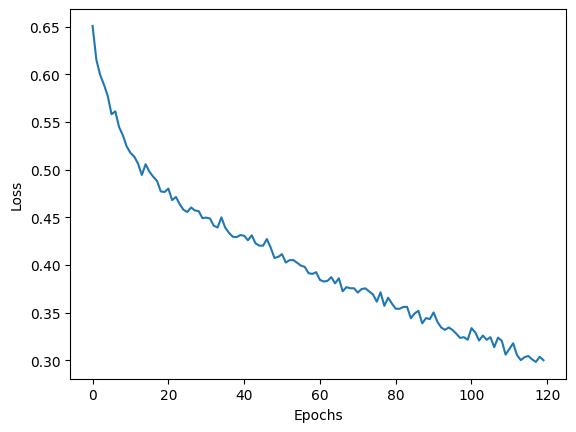

In [8]:
plt.plot(history1.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

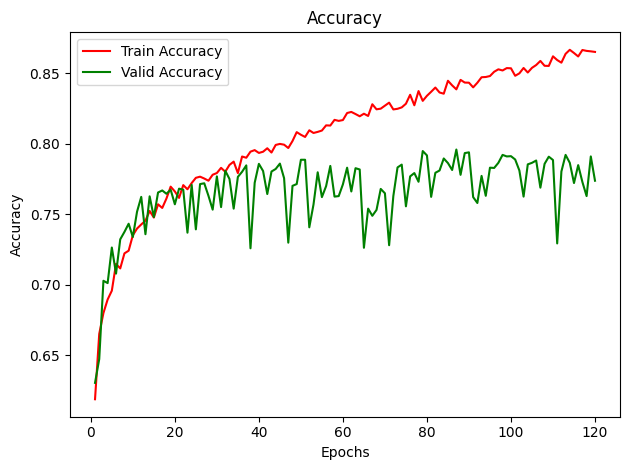

In [12]:
tr_acc = history1.history['accuracy']
tr_loss = history1.history['loss']
val_acc = history1.history['val_accuracy']
val_loss = history1.history['val_loss']

epochs = [i+1 for i in range(len(tr_acc))]


plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()